In [1]:
!pip install -e ../../

Obtaining file:///work/fukai/basicpy/BaSiCPy
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for BaSiCPy (pyproject.toml) ... done
  Created wheel for BaSiCPy: filename=BaSiCPy-1.1.0-0.editable-py3-none-any.whl size=6226 sha256=a43174716e8dd7a358b93e5416daf8bd9e881aaba9ff4e01ffe968b577e22a78
  Stored in directory: /tmp/pip-ephem-wheel-cache-w31e3x6r/wheels/86/9c/97/ba4a3013df475c562c545c92c02dc814523f7465f468313621
Successfully built BaSiCPy
  Attempting uninstall: BaSiCPy
    Found existing installation: BaSiCPy 1.1.0
    Uninstalling BaSiCPy-1.1.0:
      Successfully uninstalled BaSiCPy-1.1.0


In [3]:
import basicpy
from basicpy import datasets
from matplotlib import pyplot as plt
from skimage import io
from subprocess import check_output
from pathlib import Path
import numpy as np
import pandas as pd
import time
plt.style.use("paper_style.mplstyle")

In [4]:
basedir = Path("/work/fukai/basicpy/BaSiCPy/misc_notebooks/analysis_for_publication/")
imagedir = basedir/"testdata_for_imagej"

In [4]:
fitting_res = []

for trial in range(5):
    for name in datasets.RESCALED_TEST_DATA_PROPS.keys():
        images = datasets.fetch(name)
        filepath=str(imagedir/f"{name}.tif")
        io.imsave(filepath, images)
        print(filepath)
        for get_darkfield in [False, True]:
            res = check_output([
                f"/opt/Fiji.app/ImageJ-linux64 --headless --run imagej_macro.py \"filename='{filepath}', get_darkfield={1 if get_darkfield else 0}, lambda_flat=0.1, lambda_dark=0.01\""
            ],shell=True)
            lines = [l for l in res.decode().split("\n") if l.startswith("erapsed time")]
            assert len(lines) == 1
            erapsed_time = float(lines[0].split(":")[1])
            print(name,erapsed_time)
            fitting_res.append({
                "image_name": name,
                "trial": trial,
                "method":"ImageJ BaSiC",
                "get_darkfield": get_darkfield,
                "erapsed_time": erapsed_time
            })
fitting_res_df = pd.DataFrame.from_records(fitting_res)
fitting_res_df.to_csv("imagej_benchmark.csv")

/work/fukai/basicpy/BaSiCPy/misc_notebooks/analysis_for_publication/testdata_for_imagej/cell_culture.tif


OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


In [ ]:
import jax
jax.config.update('jax_platform_name', 'gpu')

fitting_res = []
for trial in range(5):
    for name in datasets.RESCALED_TEST_DATA_PROPS.keys():
        images = datasets.fetch(name)
        for get_darkfield in [False, True]:
            b = basicpy.BaSiC(
                fitting_mode="approximate",
                get_darkfield=get_darkfield,
                working_size=None,
                smoothness_flatfield=0.1,
                smoothness_darkfield=0.01,
                sparse_cost_darkfield=0.01,
                approx_rescale_parameters=False,
            )
            b.fit(images)
            start = time.time()
            b.fit(images)
            stop = time.time()
            erapsed_time = stop - start
            suffix = "with_darkfield" if get_darkfield else "no_darkfield"
            io.imsave(imagedir/f"jax_gpu_{name}_flatfield_{suffix}.tif",b.flatfield)
            io.imsave(imagedir/f"jax_gpu_{name}_darkfield_{suffix}.tif",b.darkfield)
            fitting_res.append({
                    "image_name": name,
                    "trial": trial,
                    "method":"GPU BaSiCPy",
                    "get_darkfield": get_darkfield,
                    "erapsed_time": erapsed_time
            })
fitting_res_df2 = pd.DataFrame.from_records(fitting_res)
fitting_res_df2.to_csv("gpu_benchmark.csv")

In [ ]:
import jax
jax.config.update('jax_platform_name', 'cpu')
fitting_res = []
for trial in range(5):
    for name in datasets.RESCALED_TEST_DATA_PROPS.keys():
        images = datasets.fetch(name)
        for get_darkfield in [False, True]:
            b = basicpy.BaSiC(fitting_mode="approximate",
                get_darkfield=get_darkfield,
                working_size=None,
                smoothness_flatfield=0.1,
                smoothness_darkfield=0.01,
                sparse_cost_darkfield=0.01,
                approx_rescale_parameters=False
            )
            b.fit(images)
            start = time.time()
            b.fit(images)
            stop = time.time()
            erapsed_time = stop - start
            suffix = "with_darkfield" if get_darkfield else "no_darkfield"
            io.imsave(imagedir/f"jax_cpu_{name}_flatfield_{suffix}.tif",b.flatfield)
            io.imsave(imagedir/f"jax_cpu_{name}_darkfield_{suffix}.tif",b.darkfield)
            fitting_res.append({
                    "image_name": name,
                    "trial": trial,
                    "method":"CPU BaSiCPy",
                    "get_darkfield": get_darkfield,
                    "erapsed_time": erapsed_time
            })
fitting_res_df3 = pd.DataFrame.from_records(fitting_res)
fitting_res_df3.to_csv("cpu_benchmark.csv")

In [5]:
fitting_res_df=pd.read_csv("imagej_benchmark.csv",index_col=0)
fitting_res_df2=pd.read_csv("gpu_benchmark.csv",index_col=0)
fitting_res_df3=pd.read_csv("cpu_benchmark.csv",index_col=0)
fitting_res_df_all = pd.concat([
    fitting_res_df,
    fitting_res_df2,
    fitting_res_df3
])

In [6]:
fitting_res_df_all.reset_index().to_csv("time_benchmark.csv")

In [7]:
fitting_res_df_all = pd.read_csv("time_benchmark.csv",index_col=0)

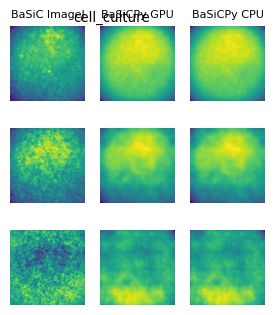

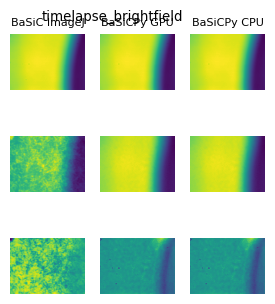

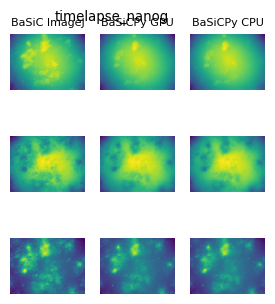

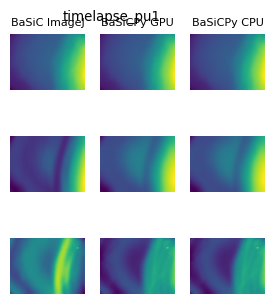

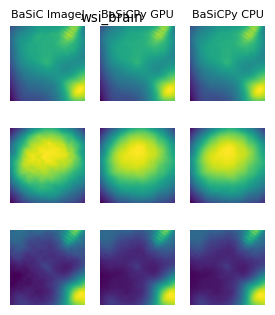

In [8]:
for name in datasets.RESCALED_TEST_DATA_PROPS.keys():
    im1 = io.imread(imagedir/f"{name}_flatfield_no_darkfield.tif")
    im2 = io.imread(imagedir/f"jax_gpu_{name}_flatfield_no_darkfield.tif")
    im3 = io.imread(imagedir/f"jax_cpu_{name}_flatfield_no_darkfield.tif")
    plt.suptitle(name)
    plt.subplot(331)
    plt.title("BaSiC ImageJ")
    plt.imshow(im1)
    plt.axis("off")
    plt.subplot(332)
    plt.title("BaSiCPy GPU")
    plt.imshow(im2)
    plt.axis("off")
    plt.subplot(333)
    plt.title("BaSiCPy CPU")
    plt.imshow(im3)
    plt.axis("off")

    im4 = io.imread(imagedir/f"{name}_flatfield_with_darkfield.tif")
    im5 = io.imread(imagedir/f"jax_gpu_{name}_flatfield_with_darkfield.tif")
    im6 = io.imread(imagedir/f"jax_cpu_{name}_flatfield_with_darkfield.tif")
    plt.subplot(334)
    plt.imshow(im4)
    plt.axis("off")
    plt.subplot(335)
    plt.imshow(im5)
    plt.axis("off")
    plt.subplot(336)
    plt.imshow(im6)
    plt.axis("off")

    im4 = io.imread(imagedir/f"{name}_darkfield_with_darkfield.tif")
    im5 = io.imread(imagedir/f"jax_gpu_{name}_darkfield_with_darkfield.tif")
    im6 = io.imread(imagedir/f"jax_cpu_{name}_darkfield_with_darkfield.tif")
    plt.subplot(337)
    plt.imshow(im4)
    plt.axis("off")
    plt.subplot(338)
    plt.imshow(im5)
    plt.axis("off")
    plt.subplot(339)
    plt.imshow(im6)
    plt.axis("off")
    plt.show()

In [9]:
summarized_df = fitting_res_df_all.groupby(["image_name","method","get_darkfield"])["erapsed_time"].agg(["mean","std"]).reset_index()

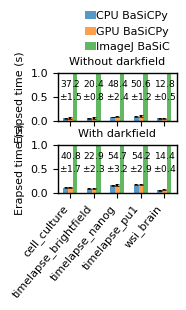

In [41]:
fig, axes = plt.subplots(2,1, figsize=(3.4/2,3),sharex=True, gridspec_kw=dict(hspace=0.5))
image_names = sorted(datasets.RESCALED_TEST_DATA_PROPS.keys())
for ax, (get_darkfield, grp) in zip(axes,summarized_df.groupby("get_darkfield")):
    ax.set_title(f"{'With' if get_darkfield else 'Without'} darkfield")
    for jj, (method, grp2) in enumerate(grp.groupby("method")):
        xs = np.arange(len(image_names)) + jj*0.2
        assert grp2["image_name"].values.tolist() == image_names
        ys = grp2["mean"]
        y_errs = grp2["std"]
        ax.bar(xs, ys, yerr=y_errs, width=0.2, label=method,
               capsize=1.5,alpha=0.75)
        if method == "ImageJ BaSiC":
            for x,y,yerr in zip(xs,ys,y_errs):
                ax.text(x-0.2, 0.9, 
                        fr"${y:.1f}$""\n"fr"$\pm{yerr:.1f}$",
                        ha="center", va="top", fontsize=6.5)
    ax.set_ylabel('Erapsed time (s)')
    ax.set_ylim(0,1)
axes[0].legend(loc='lower right', ncols=1, bbox_to_anchor=(1,1.3))
axes[1].set_xticks(np.arange(len(image_names))+0.2, 
                   image_names, 
                   rotation=50,
                   ha="right",x=10)
fig.subplots_adjust(bottom=0.35, left=0.275, right=0.975, top=0.75)
fig.savefig("figs/fig1_time_benchmark.pdf")